In [2]:
import pandas as pd
from rdkit import Chem
import numpy as np

from pathlib import Path as pt

In [1]:
from xgboost import XGBRegressor, __version__ as xgboost_version

from catboost import CatBoostRegressor, __version__ as catboost_version

from lightgbm import LGBMRegressor, __version__ as lightgbm_version
print(f'{xgboost_version=}, {catboost_version=}, {lightgbm_version=}')

xgboost_version='2.0.3', catboost_version='1.2.5', lightgbm_version='4.5.0'


In [3]:
import numpy as np
from pathlib import Path as pt

# for processing
import pandas as pd
from sklearn import metrics, __version__ as sklearn_version

print(f"Using scikit-learn version {sklearn_version}")

# models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor, kernels

# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import (
    KFold,
    cross_val_score,
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    HalvingGridSearchCV,
    HalvingRandomSearchCV,
)
from sklearn.preprocessing import StandardScaler

from dask_ml.model_selection import (
    GridSearchCV as DaskGridSearchCV,
    RandomizedSearchCV as DaskRandomizedSearchCV,
)

# for saving models
from joblib import dump
from sklearn.utils import resample

from dask.diagnostics import ProgressBar

import json
from scipy.optimize import curve_fit

Using scikit-learn version 1.5.1


In [4]:
import matplotlib.pyplot as plt

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [6]:
def linear(x, m, c):
    return m * x + c

In [7]:
loc = pt('/Users/aravindhnivas/Documents/code-testing/ML properties/')
mp_csv_file = loc / 'melting_points_updated.csv'
mp_csv_file.exists()

True

In [8]:
df = pd.read_csv(mp_csv_file, index_col=0)
df

SMILES Melting point (C)  \
0     COP(=S)(OC)OC1=CC=C(C=C1)SC2=CC=C(C=C2)OP(=S)(...           31.6(5)   
1             CC(C)C1=CC2=CCC3C(C2CC1)(CCCC3(C)C(=O)O)C             173.5   
2                CC1=CC(=O)CC(C1(C=CC(=CC(=O)O)C)O)(C)C               160   
3           COC1=CC=C(C=C1)C2=CC(=O)C3=C(C=C(C=C3O2)O)O               263   
4           CCCC(=O)NC1=CC(=C(C=C1)OCC(CNC(C)C)O)C(=O)C               121   
...                                                 ...               ...   
7976   CCCCN(CCCC)C(=S)[S-].CCCCN(CCCC)C(=S)[S-].[Zn+2]               138   
7977                             C[CH2-].C[CH2-].[Zn+2]         -33.34(2)   
7979                   CC(=CC(=O)C)O.CC(=CC(=O)C)O.[Zn]          127.3(2)   
7980               CN(C)C(=S)[S-].CN(C)C(=S)[S-].[Zn+2]               250   
7981                     Cl[Zr](Cl)(C1C=CC=C1)C2C=CC=C2               248   

      MP (processed)  
0              31.60  
1             173.50  
2             160.00  
3             263.00  
4             121.00  
...              ...  
7976          138.00  
7977          -33.34  
7979          127.30  
7980          250.00  
7981          248.00  

[7437 rows x 3 columns]

In [9]:
embedding_file = loc / 'melting_points_updated_SMILES_VICGAE_embeddings.npy'
embedding_file.exists()

True

In [10]:
X = np.load(embedding_file, allow_pickle=True)
X.shape

(7437, 32)

In [11]:
y = df['MP (processed)'].values
y.shape

(7437,)

In [12]:
invalid_indices = [i for i, arr in enumerate(X) if np.any(arr == 0)]
valid_mask = np.ones(len(X), dtype=bool)  # Initially, mark all as valid
valid_mask[invalid_indices] = False  # Mark invalid indices as False
X = X[valid_mask]  # Keep only the rows that are marked as True in the valid_mask
y = y[valid_mask]
X.shape, y.shape

((7123, 32), (7123,))

In [13]:
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=float(test_size))
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5698, 32), (1425, 32), (5698,), (1425,))

In [21]:
def main(model, CV=False):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

    r2 = metrics.r2_score(y_test_original, y_pred)
    mse = metrics.mean_squared_error(y_test_original, y_pred)
    rmse = np.sqrt(mse)
    mae = metrics.mean_absolute_error(y_test_original, y_pred)

    # print(f"R2: {r2:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

    pop, _ = curve_fit(linear, y_test_original, y_pred)
    y_linear_fit = linear(y_test_original, *pop)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(y_test_original, y_pred, 'o', label='XGBoost')
    ax.plot(y_test_original, y_linear_fit, label='Linear fit')
    ax.set_xlabel('True MP (°C)')
    ax.set_ylabel('Predicted MP (°C)')
    ax.legend()
    ax.title.set_text(f"{model.__class__.__name__}: R$^2$ = {r2:.2f}, MSE = {mse:.2f}, RMSE = {rmse:.2f}, MAE = {mae:.2f}")
    
    if CV:
        cv_scores = cross_val_score(model, X, y, cv=10, scoring="r2")
        print(f"Mean CV R2 score: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})")
    
    return model

Learning rate set to 0.053899
0:	learn: 0.9895556	total: 2.65ms	remaining: 2.65s
1:	learn: 0.9692278	total: 4.37ms	remaining: 2.18s
2:	learn: 0.9510649	total: 6.07ms	remaining: 2.02s
3:	learn: 0.9323165	total: 7.96ms	remaining: 1.98s
4:	learn: 0.9146385	total: 9.66ms	remaining: 1.92s
5:	learn: 0.8985141	total: 12.2ms	remaining: 2.02s
6:	learn: 0.8850429	total: 14.1ms	remaining: 2s
7:	learn: 0.8720575	total: 15.8ms	remaining: 1.95s
8:	learn: 0.8592143	total: 17.3ms	remaining: 1.91s
9:	learn: 0.8476133	total: 18.9ms	remaining: 1.87s
10:	learn: 0.8377225	total: 21ms	remaining: 1.88s
11:	learn: 0.8282807	total: 23ms	remaining: 1.9s
12:	learn: 0.8183089	total: 24.6ms	remaining: 1.87s
13:	learn: 0.8079572	total: 26.2ms	remaining: 1.84s
14:	learn: 0.7996200	total: 28.7ms	remaining: 1.88s
15:	learn: 0.7921234	total: 31.1ms	remaining: 1.91s
16:	learn: 0.7846887	total: 33.3ms	remaining: 1.93s
17:	learn: 0.7778016	total: 35.4ms	remaining: 1.93s
18:	learn: 0.7700786	total: 38.6ms	remaining: 1.99s


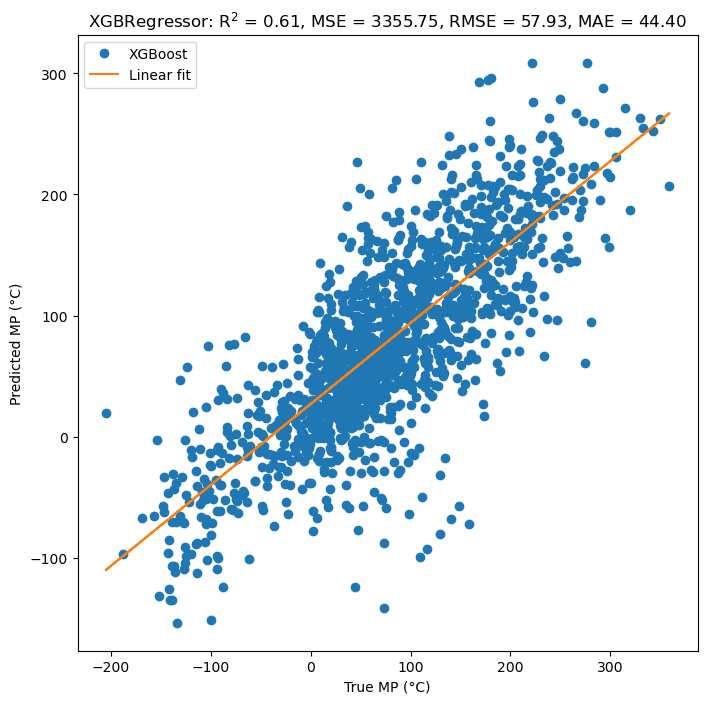

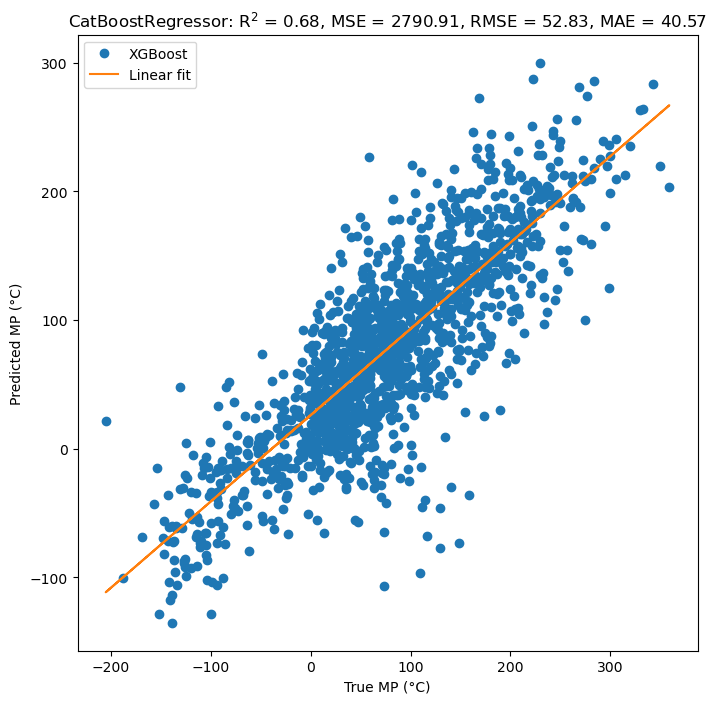

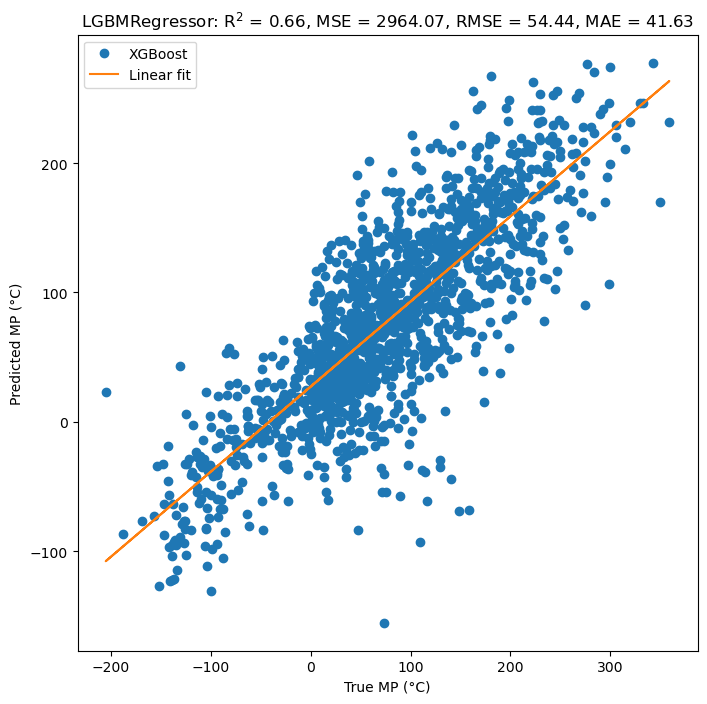

In [22]:
# model = XGBRegressor(n_jobs=-1, verbosity=1)
# model = CatBoostRegressor()
# model = LGBMRegressor(metric='rmse') 
_ = main(XGBRegressor(n_jobs=-1, verbosity=1) )
_ = main(CatBoostRegressor() )
_ = main(LGBMRegressor(metric='rmse') )

In [24]:
# Define parameter grids for each model
lgbm_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'num_leaves': [31, 63, 127]
}

catboost_param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5, 7]
}

xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5]
}

# Function to perform grid search and return best model
def grid_search_model(model, param_grid):
    grid_search = GridSearchCV(model, param_grid, cv=3, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_

# Function to evaluate model
def evaluate_model(model):
    y_pred = model.predict(X_test)
    mse = metrics.mean_squared_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)
    return mse, r2

In [25]:
# Fine-tune LightGBM
print("Fine-tuning LightGBM...")
lgbm_model, lgbm_best_params = grid_search_model(LGBMRegressor(random_state=42), lgbm_param_grid)
lgbm_mse, lgbm_r2 = evaluate_model(lgbm_model)
print("LightGBM - Best parameters:", lgbm_best_params)
print(f"LightGBM - MSE: {lgbm_mse:.4f}, R2: {lgbm_r2:.4f}")

# Fine-tune CatBoost
print("Fine-tuning CatBoost...")
catboost_model, catboost_best_params = grid_search_model(CatBoostRegressor(random_state=42, verbose=False), catboost_param_grid)
catboost_mse, catboost_r2 = evaluate_model(catboost_model)
print("\nCatBoost - Best parameters:", catboost_best_params)
print(f"CatBoost - MSE: {catboost_mse:.4f}, R2: {catboost_r2:.4f}")

# Fine-tune XGBoost
print("Fine-tuning XGBoost...")
xgb_model, xgb_best_params = grid_search_model(XGBRegressor(random_state=42), xgb_param_grid)
xgb_mse, xgb_r2 = evaluate_model(xgb_model)

print("\nXGBoost - Best parameters:", xgb_best_params)
print(f"XGBoost - MSE: {xgb_mse:.4f}, R2: {xgb_r2:.4f}")

Fine-tuning LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 3799, number of used features: 32
[LightGBM] [Info] Number of data points in the train set: 3799, number of used features: 32
[LightGBM] [Info] Number of data points in the train set: 3799, number of used features: 32
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026197 seconds.
You can 

In [ ]:
model.get_params()

In [ ]:
# grid search
xgb_model = XGBRegressor(
    n_jobs=-1, 
    verbosity=1,
)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9],
    'gamma': [0, 0.1],
    'reg_alpha': [0, 1],
    'reg_lambda': [0, 1]
}
grid_search = GridSearchCV(
# grid_search = RandomizedSearchCV(
# grid_search = HalvingRandomSearchCV(
# grid_search = HalvingGridSearchCV(
    xgb_model, param_grid, cv=3, n_jobs=-1, 
    # verbose=1, 
    # n_iter=100,  # number of parameter settings that are sampled
)

# Ensure X_train and y_train are correctly formatted
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


# Check for NaN values
print(f"X_train contains NaN: {np.isnan(X_train).any()}")
print(f"y_train contains NaN: {np.isnan(y_train).any()}")

try:
    grid_search.fit(X_train, y_train)
except ValueError as e:
    print(f"ValueError: {e}")

# grid_results = pd.DataFrame(grid_search.cv_results_)
# grid_results = grid_results.sort_values(by='rank_test_score')
# grid_results.to_csv(loc / f'grid_search_results_{xgb_model.__class__.__name__}.csv', index=False)

# Access the best estimator if fit is successful
if grid_search.best_estimator_:
    best_model = grid_search.best_estimator_
    _ = main(best_model)

In [ ]:
grid_search.best_params_, grid_search.best_score_

In [ ]:
grid_results = pd.DataFrame(grid_search.cv_results_)
grid_results = grid_results.sort_values(by='rank_test_score')
grid_results.to_csv(loc / f'grid_search_results_{xgb_model.__class__.__name__}.csv', index=False)

In [ ]:
xgb_model.get_params()

## Neural network

In [13]:
# Custom dataset
class MoleculeDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [14]:
# Neural Network model
class MeltingPointMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_rate):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        return self.fc3(x)

In [15]:
# Training function
def train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=100, early_stopping_patience=10):
    model.to(device)
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()
        
        val_loss /= len(val_loader)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch}")
                break

    return model

In [16]:
# Objective function for Optuna
def objective(trial):
    # Hyperparameters to optimize
    hidden_dim = trial.suggest_int('hidden_dim', 32, 256)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])

    # Create model, optimizer, and criterion
    model = MeltingPointMLP(input_dim=32, hidden_dim=hidden_dim, dropout_rate=dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Train the model
    trained_model = train_model(model, train_loader, val_loader, optimizer, criterion, device)

    # Evaluate the model
    trained_model.eval()
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = trained_model(inputs)
            val_predictions.extend(outputs.cpu().numpy())
            val_targets.extend(targets.cpu().numpy())

    val_r2 = metrics.r2_score(val_targets, val_predictions)
    return val_r2

In [17]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Create datasets
train_dataset = MoleculeDataset(X_train_scaled, y_train)
val_dataset = MoleculeDataset(X_val_scaled, y_val)
test_dataset = MoleculeDataset(X_test_scaled, y_test)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameter optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Get the best hyperparameters
best_params = study.best_params

# Train the final model with the best hyperparameters
best_model = MeltingPointMLP(input_dim=32, hidden_dim=best_params['hidden_dim'], dropout_rate=best_params['dropout_rate'])
best_optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
criterion = nn.MSELoss()

train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'])

final_model = train_model(best_model, train_loader, val_loader, best_optimizer, criterion, device)

# Evaluate on test set
test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'])
final_model.eval()
test_predictions = []
test_targets = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = final_model(inputs)
        test_predictions.extend(outputs.cpu().numpy())
        test_targets.extend(targets.cpu().numpy())

test_r2 = metrics.r2_score(test_targets, test_predictions)
test_rmse = np.sqrt(metrics.mean_squared_error(test_targets, test_predictions))

print(f"Test R² score: {test_r2}")
print(f"Test RMSE: {test_rmse}")

: 